In [ ]:
!pip install gensim
# !pip install gensim==4.2.0 --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 72.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string
import re
import warnings
import gensim.downloader as api
import gensim
warnings.filterwarnings("ignore")
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Input,Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **LSTM-word-embeddings Model**

In [ ]:
data = pd.read_csv("/content/data/final_filtered_annotated_reviews.csv")

In [ ]:
data.shape

(13594, 2)

In [ ]:
data.columns

Index(['the_review', 'topics'], dtype='object')

In [ ]:
data.head()

,the_review,topics
0,I wish I would have gotten one earlier. I love...,mouse
1,It is so slow and lags find a better option,mouse
2,Beautifully produced and lovely to look at for...,mouse
3,I don't typically write reviews but I keep hav...,mouse
4,"I bought this in late June, it looks cool with...",mouse


In [ ]:
data.head()

,the_review,topics
0,I wish I would have gotten one earlier. I love...,mouse
1,It is so slow and lags find a better option,mouse
2,Beautifully produced and lovely to look at for...,mouse
3,I don't typically write reviews but I keep hav...,mouse
4,"I bought this in late June, it looks cool with...",mouse


### **Data Preprocessing**

In [ ]:
def preprocess(sent):
    '''Cleans text data up, leaving only 2 or
        more char long non-stopwords composed of A-Z & a-z only
        in lowercase'''
    # lowercase
    sentence = sent.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ",sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Removing digits
    sentence = sentence.translate(str.maketrans('', '', string.digits))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) 
    # When we remove apostrophe from the word "Mark's", 
    # the apostrophe is replaced by an empty space. 
    # Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  
    # Next, we remove all the single characters and replace it by a space 
    # which creates multiple spaces in our text. 
    # Finally, we remove the multiple spaces from our text as well.

    return sentence


In [ ]:
text_cleaned = data.copy()
text_cleaned['cleaned_review'] = text_cleaned.the_review.apply(preprocess)

In [ ]:
columns_needed = [
    "cleaned_review",
    "topics"
]

In [ ]:
model_data = text_cleaned[columns_needed]

In [ ]:
model_data.sample(2,random_state=42)

,cleaned_review,topics
1061,it is nice mouse and liked that it came with a...,mouse
3881,worth it,headphone


In [ ]:
topics = model_data.topics.unique().tolist()
topics_mappings = {}
for index,value in enumerate(topics):
    topics_mappings[value]=index
topics_mappings

{'mouse': 0, 'headphone': 1, 'keyboard_speakers': 2}

In [ ]:
model_data['topic_label'] = model_data.topics.map(topics_mappings)

In [ ]:
model_data.head()

,cleaned_review,topics,topic_label
0,i wish would have gotten one earlier love it a...,mouse,0
1,it is so slow and lags find better option,mouse,0
2,beautifully produced and lovely to look at for...,mouse,0
3,i don typically write reviews but keep having ...,mouse,0
4,i bought this in late june it looks cool with ...,mouse,0


In [ ]:
list(api.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

### **Generating the Embeddings**

In [ ]:
# https://github.com/piskvorky/gensim-data?tab=readme-ov-file
# https://radimrehurek.com/gensim/models/word2vec.html#embeddings-with-multiword-ngrams
glove_vectors_300 = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_sm", exclude=["tagger", "ner",'attribute_ruler'])
nlp.pipe_names

['tok2vec', 'parser', 'lemmatizer']

In [ ]:
def spacy_tokeniser(sentence):
    sentence  = sentence.strip().lower()
    doc = nlp(sentence)
    my_tokens = [word.lemma_ for word in doc if word.text not in STOP_WORDS]
    return my_tokens

model_data['tokens'] = model_data['cleaned_review'].apply(spacy_tokeniser)

**Text Sequencing**

Now we tokenize the sentences and convert X into sequences of numbers:

- Embedding layer expects the words to be in numeric form
- Using Tokenizer function from keras.preprocessing.text library
- Method fit_on_text trains the tokenizer
- Method texts_to_sequences converts sentences to their numeric form

In [ ]:
X = model_data.loc[:,'tokens']
X[0]

['wish', 'gotten', 'earlier', 'love', 'makes', 'working', 'laptop', 'easier']

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)

X = word_tokenizer.texts_to_sequences(X)
X[0]

[150, 470, 2525, 6, 133, 48, 33, 491]

In [ ]:
# Find the longest word length to know how to apply padding
review_max_length = max([len(review) for review in X])
review_max_length # 285

285

In [ ]:
len(word_tokenizer.word_index) # vocab size in the

8470

In [ ]:
vocab = word_tokenizer.word_index.items()

# Let's see the first 10
for index, word in enumerate(vocab):
    print(f"{word[0]} : {word[1]}")
    if index == 10:
        break

mouse : 1
great : 2
sound : 3
use : 4
good : 5
love : 6
like : 7
quality : 8
works : 9
work : 10
charge : 11


In [ ]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

8471

In [ ]:
max_length = review_max_length
max_length # will be used for padding

285

In [ ]:
# Apply padding
X = pad_sequences(X, padding='post', maxlen=max_length)

**The Embedding Matrix**

In [ ]:
print(f"Vocab size in embedding model: {len(glove_vectors_300.key_to_index.keys()):,}")

Vocab size in embedding model: 400,000


In [ ]:
# glove_vectors_300['model']

In [ ]:
# Create Embedding Matrix having 300 columns
glove_vectors_300_size = glove_vectors_300.vector_size
embedding_matrix = np.zeros((vocab_length,glove_vectors_300_size))
print(embedding_matrix.shape)
print(embedding_matrix.ndim)

(8471, 300)
2


In [ ]:
embedding_matrix[:5,:2] # empty array

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [ ]:
vocab

dict_items([('mouse', 1), ('great', 2), ('sound', 3), ('use', 4), ('good', 5), ('love', 6), ('like', 7), ('quality', 8), ('works', 9), ('work', 10), ('charge', 11), ('keyboard', 12), ('battery', 13), ('speaker', 14), ('lights', 15), ('price', 16), ('nice', 17), ('gaming', 18), ('headset', 19), ('product', 20), ('easy', 21), ('usb', 22), ('time', 23), ('don', 24), ('bought', 25), ('light', 26), ('long', 27), ('recommend', 28), ('got', 29), ('pretty', 30), ('doesn', 31), ('color', 32), ('laptop', 33), ('buy', 34), ('colors', 35), ('ve', 36), ('life', 37), ('little', 38), ('better', 39), ('comfortable', 40), ('headphones', 41), ('wireless', 42), ('mic', 43), ('jbl', 44), ('noise', 45), ('perfect', 46), ('quiet', 47), ('working', 48), ('computer', 49), ('far', 50), ('need', 51), ('loud', 52), ('amazing', 53), ('loves', 54), ('hear', 55), ('son', 56), ('thing', 57), ('charging', 58), ('way', 59), ('cool', 60), ('click', 61), ('feel', 62), ('day', 63), ('super', 64), ('best', 65), ('small', 

In [ ]:
glove_vectors_300_size

300

In [ ]:
# populating the array
for word, index in vocab:
  if word in glove_vectors_300.key_to_index.keys():
    embedding_matrix[index] = glove_vectors_300[word]
  else:
    embedding_matrix[index] = np.zeros(glove_vectors_300_size)

In [ ]:
print(embedding_matrix.shape)
print(embedding_matrix.ndim)

(8471, 300)
2


In [ ]:
embedding_matrix[:5,:2]

array([[ 0.        ,  0.        ],
       [-0.77104002, -0.0090132 ],
       [ 0.23188999, -0.19536   ],
       [ 0.072236  , -0.064091  ],
       [-0.10515   ,  0.13406999]])

In [ ]:
y = tf.keras.utils.to_categorical(model_data.topic_label.values,
                                  num_classes=3)

In [ ]:
X

array([[ 150,  470, 2525, ...,    0,    0,    0],
       [ 528,  894,  174, ...,    0,    0,    0],
       [1418, 2281, 1958, ...,    0,    0,    0],
       ...,
       [ 237,    0,    0, ...,    0,    0,    0],
       [  14,  598,    3, ...,    0,    0,    0],
       [  11,   46,  261, ...,    0,    0,    0]], dtype=int32)

In [ ]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

### **Model Training & Metrics**

In [ ]:
# from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,\
ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline

# To be able to plot AUC_ROC curve
from sklearn.preprocessing import label_binarize

In [ ]:
# https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
# https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html

In [ ]:
bin_classes = 3
y_binarize = label_binarize(y, classes=[0,1,2])

num_classes = y_binarize.shape[1]

In [ ]:
X = X
y = y_binarize

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binarize,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y_binarize)

In [ ]:
# Define the LSTM mdoel here using
# functional approach and wrap it in a function
def lstm_model(embedding_layer):
  x = embedding_layer
  x = LSTM(128,return_sequences=True, name="LSTM-1")(x)
  x = Dropout(0.2,name="Dropout-1")(x)
  x = LSTM(64, name="LSTM-2")(x)
  x = Dropout(0.2,name="Dropout-2")(x)
  # x = LSTM(32, name="LSTM-3")(x)
  # x = Dropout(0.2,name="Dropout3")(x)
  return x

**Define custom callbacks**

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):
  def __init__(self):
     super(MyCustomCallback,self).__init__()

  def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            val_loss = logs.get("val_loss")
            loss = logs.get('loss')
            val_acc = logs.get('val_accuracy')
            acc = logs.get('accuracy')
            if val_loss < 0.2:
              print(f"\nValidation loss is less than 0.2. \nStopping training.\n")
              self.model.stop_training = True
            elif (val_acc >= 0.85 ) and (val_loss <= 0.2  ):
                print(f"\nValidation loss is <= 0.2 or val_acc >= 0.85\nStopping training.\n")
                self.model.stop_training = True

callback = MyCustomCallback()

In [ ]:
# optimizer
optimize = tf.keras.optimizers.Adam(learning_rate=0.01)
# losses
loss = tf.keras.losses.categorical_crossentropy
# metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [ ]:
def full_model(max_length,vocab_length,\
               glove_vectors_300_size,\
               optimize,loss,precision,recall,\
               embedding_matrix):
  input_layer = Input(shape=(max_length,), name="Input-Layer")
  embedding_layer = Embedding(vocab_length,
                              glove_vectors_300_size,
                              weights=[embedding_matrix],
                              input_length=max_length,
                              trainable=False,
                              name="Embedding-Layer")(input_layer)
  hidden_layer = lstm_model(embedding_layer)
  output_layer = Dense(3, activation='softmax', name="Output-Layer")(hidden_layer)
  model = Model(inputs=input_layer, outputs=output_layer)
  model.compile(
    optimizer=optimize,
    loss=loss,
    metrics=['accuracy',precision,recall]
)
  return model

In [ ]:
model = full_model(max_length,vocab_length,\
                   glove_vectors_300_size,\
                   optimize,loss,precision,recall,\
                   embedding_matrix)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input-Layer (InputLayer)        │ (None, 285)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding-Layer (Embedding)     │ (None, 285, 300)       │     2,541,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM-1 (LSTM)                   │ (None, 285, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout-1 (Dropout)             │ (None, 285, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM-2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout-2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,810,551 (10.72 MB)

 Trainable params: 269,251 (1.03 MB)

 Non-trainable params: 2,541,300 (9.69 MB)

In [ ]:
# Resampling the data
under_sampler = RandomUnderSampler(random_state=42)

X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

In [ ]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(8964, 285)
(8964, 3)


In [ ]:
X_train_resampled

array([[ 162, 1335,   31, ...,    0,    0,    0],
       [   2,   20,    4, ...,    0,    0,    0],
       [   1,  205,  249, ...,    0,    0,    0],
       ...,
       [   2,   12,   39, ...,    0,    0,    0],
       [  46,  390,  720, ...,    0,    0,    0],
       [ 692,   36,  294, ...,    0,    0,    0]], dtype=int32)

In [ ]:
y_train_resampled

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [ ]:
import time
start = time.time()
# # Model training
tf.keras.backend.clear_session()
model_history = model.fit(X_train_resampled,
                          y_train_resampled,
                          epochs=100,
                          batch_size=128,
                          verbose=1,
                          # steps_per_epoch=100,
                          validation_split=.2,
                          callbacks=[
                              callback,
                                     ])
end = time.time()
print(f" Training time: {end-start} in seconds")

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.4262 - loss: 1.0697 - precision: 0.4215 - recall: 0.0517 - val_accuracy: 0.0000e+00 - val_loss: 1.6881 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4250 - loss: 1.0342 - precision: 0.3281 - recall: 0.0105 - val_accuracy: 5.5772e-04 - val_loss: 1.8764 - val_precision: 1.0000 - val_recall: 5.5772e-04
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4211 - loss: 1.0349 - precision: 0.4246 - recall: 7.9318e-04 - val_accuracy: 0.0000e+00 - val_loss: 1.8661 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4088 - loss: 1.0356 - precision: 0.4062 - recall: 0.0388 - val_accuracy: 0.0000e+00 - val_loss: 1.8105 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.4146 - loss: 1.0291 - precision: 0.6034 - rec

In [ ]:
full_seconds = end - start
def convert_from_seconds(seconds):
  hours = int(seconds // 3600)
  minutes = int((seconds % 3600) // 60)
  seconds = int(seconds % 60)
  print(f"{hours} hours {minutes} minutes {seconds} seconds")
convert_from_seconds(full_seconds)

0 hours 4 minutes 38 seconds


In [ ]:
y_pred_train = model.predict(X_train_resampled)

281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [ ]:
y_train_resampled_true = np.argmax(y_train_resampled, axis=1)
y_pred_train = np.argmax(y_pred_train, axis=1)

In [ ]:
# Classification report train data
sns.set_theme(style="white")
def class_report(model_name,data,y_true,y_predict):
    print(classification_report(y_true,y_predict))
    cm = confusion_matrix(y_true,y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    plt.savefig(f"/content/img/{data}_confusion_matrix_{model_name}")
    plt.show()

              precision    recall  f1-score   support

           0       0.33      1.00      0.50      2988
           1       0.00      0.00      0.00      2988
           2       1.00      0.00      0.00      2988

    accuracy                           0.33      8964
   macro avg       0.44      0.33      0.17      8964
weighted avg       0.44      0.33      0.17      8964



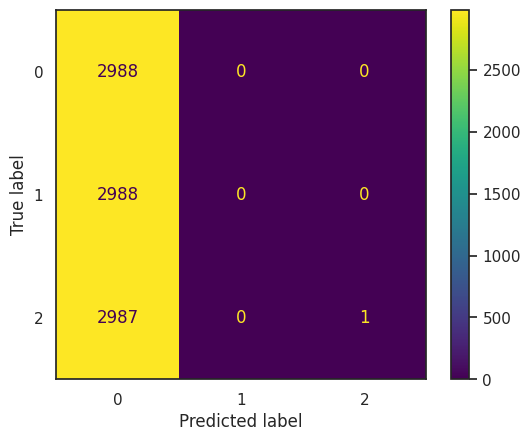

In [ ]:
class_report('LSTM-word-embeddings',"train_set",y_train_resampled_true,y_pred_train)

In [ ]:
# https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html?highlight=roc#yellowbrick.classifier.rocauc.ROCAUC

In [ ]:
# Model Performance Charts

def plot_graphs_accuracy(model:string):
  # Accuracy
  plt.plot(model_history.history['accuracy'])
  plt.plot(model_history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.savefig(f"/content/img/{model}_accuracy.png")
  plt.show()

def plot_graphs_loss(model:string):
  # Loss
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.savefig(f"/content/img/{model}_loss.png")
  plt.show()

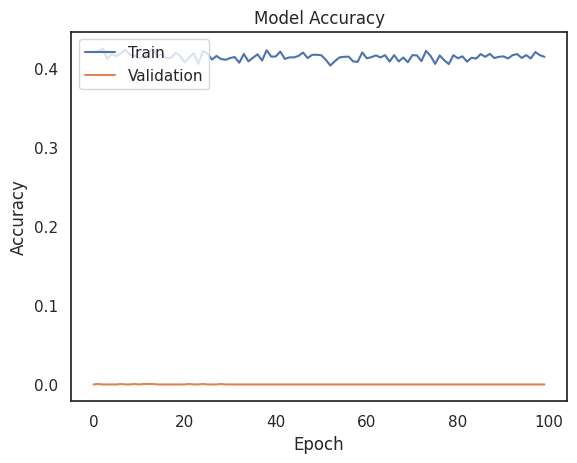

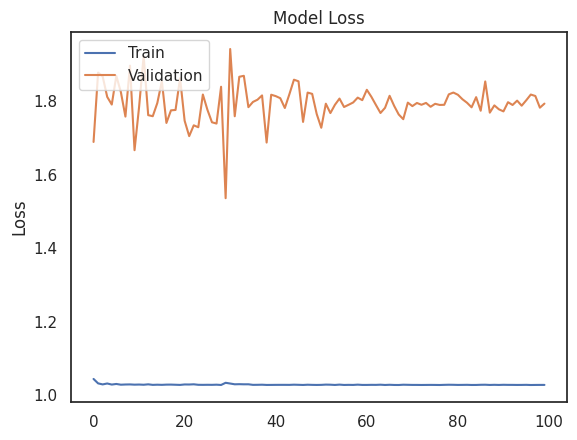

In [ ]:
plot_graphs_accuracy('LSTM-word-embeddings')
plot_graphs_loss('LSTM-word-embeddings')

### **Plotting the ROCAUC Curve**

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score, auc

fpr = {}
tpr = {}
roc_auc = {}

lw = 2

classes_by_names = ['mouse','headphone','keyboard_speakers']

def roc_curve_plot(model_name,model,data,y_true,X_features):
  y_pred = model.predict(X_features)
  for i in range(len(classes_by_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i],
             lw=lw,
             label=f'ROC of class {classes_by_names[i]}, AUC = {np.round(roc_auc[i],2)}')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right", frameon=True)
  plt.savefig(f"/content/img/{model_name}_{data}_roc_curve.png")
  plt.show()
  roc_auc_scoring_macro_ovr = roc_auc_score(y_true,y_pred,
                                            multi_class="ovr",
                                            average="macro")
  print(f"AUC macro-averaged score over all classes:{np.round(roc_auc_scoring_macro_ovr,2)}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


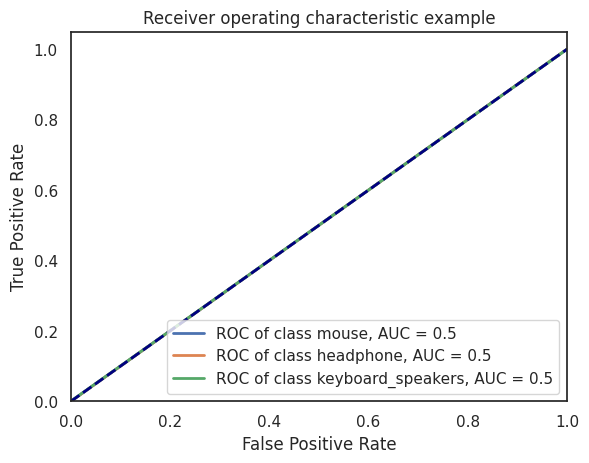

AUC macro-averaged score over all classes:0.5


In [ ]:
roc_curve_plot('LSTM-word-embeddings',model,"train_set",y_train_resampled,X_train_resampled)

{'mouse': 0, 'headphone': 1, 'keyboard_speakers': 2}

### **Model Test & Metrics**

In [ ]:
y_pred_test = model.predict(X_test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [ ]:
y_test_true = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(y_pred_test, axis=1)

              precision    recall  f1-score   support

           0       0.40      1.00      0.57      1093
           1       0.00      0.00      0.00       879
           2       0.00      0.00      0.00       747

    accuracy                           0.40      2719
   macro avg       0.13      0.33      0.19      2719
weighted avg       0.16      0.40      0.23      2719



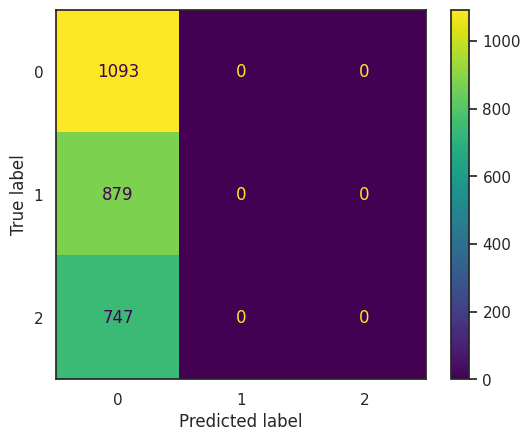

In [ ]:
# Classification report test data
class_report('LSTM-word-embeddings',
             "test_set",
             y_test_true,
             y_pred_test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


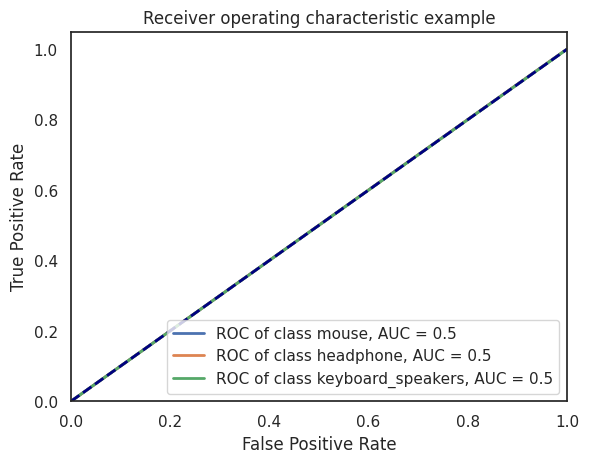

AUC macro-averaged score over all classes:0.5


In [ ]:
roc_curve_plot('LSTM-word-embeddings',
               model,
               "test_set",
               y_test,
               X_test)